In [1]:
### Model Understanding with CAPTUM
#### Link: https://pytorch.org/tutorials/beginner/introyt/captumyt.html

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
model = models.resnet101(pretrained=True)
model = model.eval()

/home/irikos/anaconda3/envs/pytorch_tutorials/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/irikos/anaconda3/envs/pytorch_tutorials/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


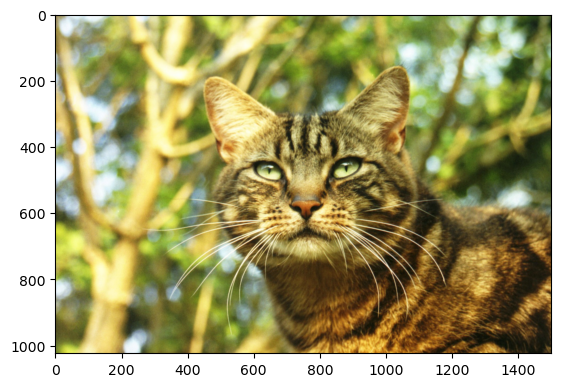

In [4]:
test_img = Image.open("resources/cat.jpg")
test_img_data = np.asanyarray(test_img)
plt.imshow(test_img_data)
plt.show()

In [5]:
# model expects 224x224 3-color image
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# standar ImageNet normalization
transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [6]:
transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = "resources/imagenet_class_index.json"

with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [7]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label  = idx_to_labels[str(pred_label_idx.item())][1]
print("Predicted: ", predicted_label, "(", prediction_score.squeeze().item(), ")")

Predicted:  tabby ( 0.621123731136322 )


#### Feature Attribution with Integrated Gradients

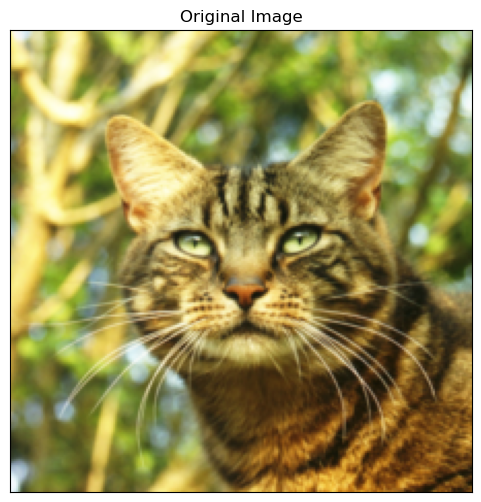

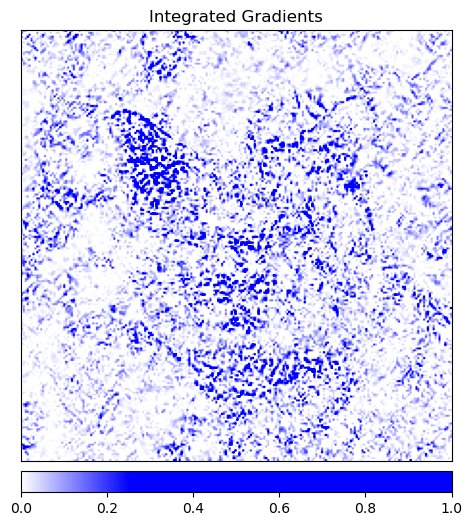

In [8]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(
    None, 
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
    method="original_image", title="Original Image"
)

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue",
    [(0, '#ffffff'),
    (0.25, '#0000ff'),
    (1, '#0000ff')], N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    method="heat_map",
    cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    title="Integrated Gradients"
)

#### Feature Attributon with Occlusion

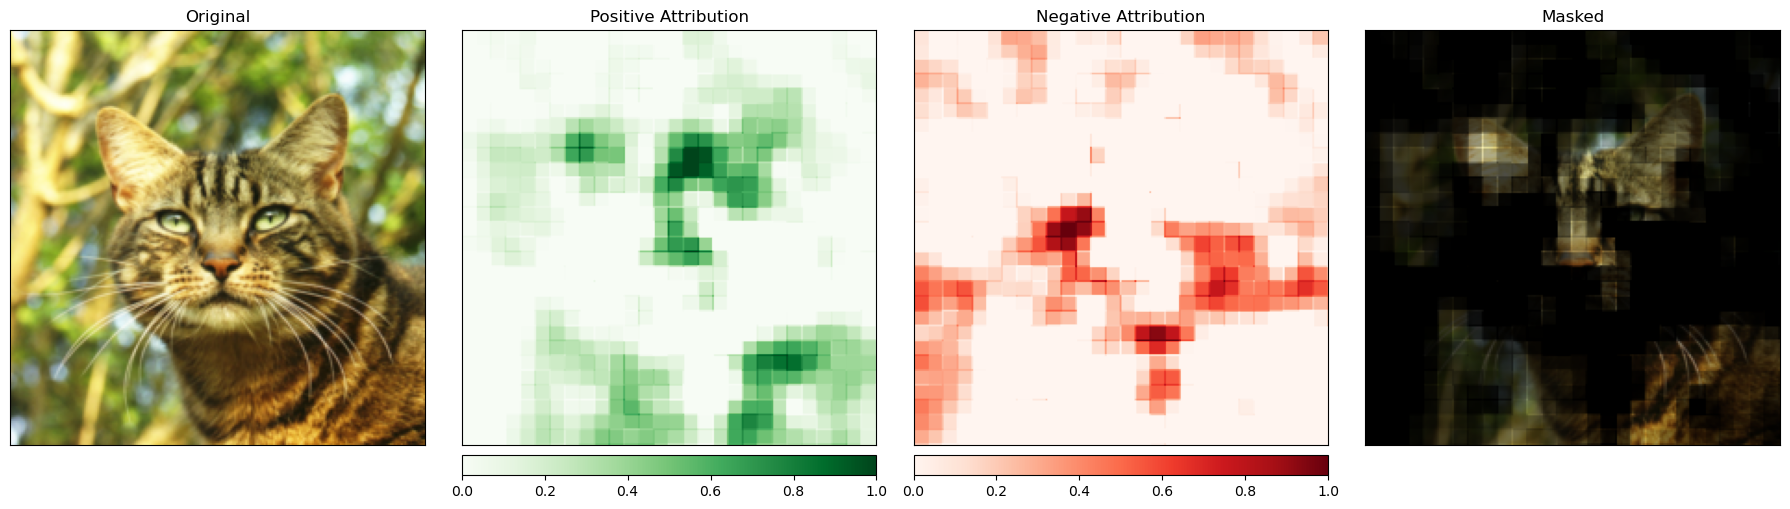

In [9]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    input_img,
    target=pred_label_idx,
    strides=(3, 8, 8),
    sliding_window_shapes=(3, 15, 15),
    baselines=0
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
    ["original_image", "heat_map", "heat_map", "masked_image"],
    ["all", "positive", "negative", "positive"],
    show_colorbar=True,
    titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
    fig_size=(18, 6)
)

#### Layer Attribution with Layer GradCAM

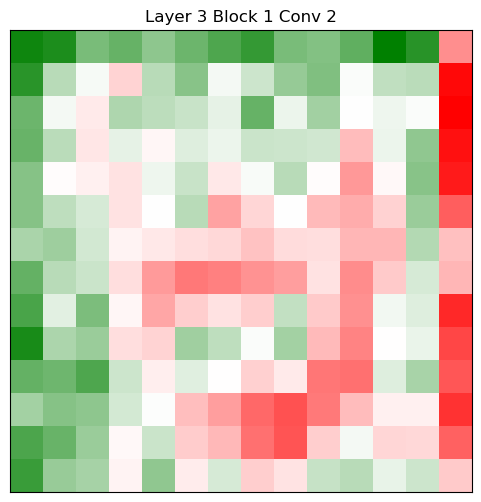

In [10]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(
    attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    sign="all",
    title="Layer 3 Block 1 Conv 2"
)

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


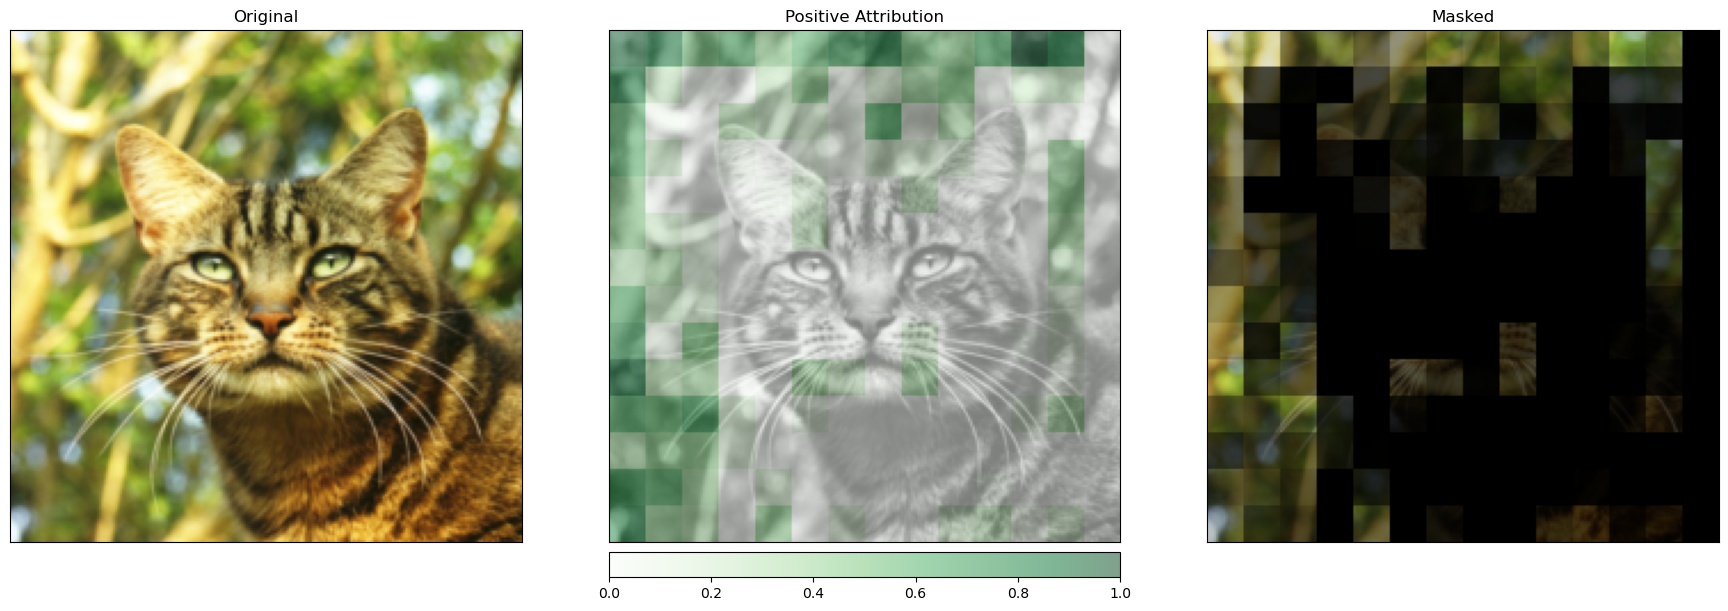

In [11]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    transformed_img.permute(1,2,0).numpy(),
    ["original_image", "blended_heat_map", "masked_image"],
    ["all", "positive", "positive"],
    show_colorbar=True,
    titles=["Original", "Positive Attribution", "Masked"],
    fig_size=(18,6)
)


#### Visualization with Captum Insights

In [12]:
imgs = ["resources/cat.jpg", "resources/teapot.jpg", "resources/trilobite.jpg"]

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.621123731136322 )
Predicted: teapot / 849  ( 0.9149237275123596 )
Predicted: trilobite / 69  ( 0.999591052532196 )


In [13]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [14]:
# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i

input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)


visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

In [15]:
visualizer.render() #

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()

In [17]:
visualizer.serve(debug=True)


Fetch data and view Captum Insights at http://localhost:41783/



41783

127.0.0.1 - - [23/Oct/2022 17:17:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2022 17:17:08] "GET /static/css/main.fac91593.chunk.css HTTP/1.1" 304 -
127.0.0.1 - - [23/Oct/2022 17:17:08] "GET /static/js/2.c6c4604e.chunk.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Oct/2022 17:17:09] "GET /static/js/main.bf7d438b.chunk.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Oct/2022 17:17:09] "GET /init HTTP/1.1" 200 -
127.0.0.1 - - [23/Oct/2022 17:17:10] "GET /init HTTP/1.1" 200 -
